# K data models training

In this notebook several NN architectures are trained on Kapton substrate device's data and tested then in the data from the Tattoo Paper substrate device's data. 

# Imports

In [3]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.optim.lr_scheduler import ExponentialLR
from sklearn import metrics
import seaborn as sns
from torchmetrics.classification import MulticlassF1Score

# Read kapton data

In [4]:
df = pd.read_csv('kapton_data.csv', sep = ';')

# Split data, create weights

In [6]:
# Read data
data = df
X = data.drop(columns = ['Time', 'AP']) 
for c in X.columns:
    X[c] = X[c] / X[c].abs().max()
y = data['AP']

encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

# Convert to 2D PyTorch tensors
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

In [7]:
class_counts = torch.bincount(y)
data_size = len(y)

class_weights = data_size / (len(class_counts) * class_counts)
class_weights

tensor([0.1623, 2.4129, 3.4938, 2.2212, 2.1500, 2.1779, 2.3131, 2.1922, 2.1922,
        2.3957])

# Training Function

In [36]:
# Helper function to train one model
def model_train(model, X_train, y_train, X_val, y_val, train_again = False, lr = 0.0001, lr_step = False, class_weights = class_weights):
    # loss function and optimizer
    loss_fn = nn.CrossEntropyLoss(weight = class_weights)  
    optimizer = optim.Adam(model.parameters(), lr= lr)
    
    if lr_step:
        lr_scheduler = ExponentialLR(optimizer, gamma = 0.99)

    if train_again:
        n_epochs = 1000 # number of epochs to run
        batch_size = 5  # size of each batch
    else:
        n_epochs = 500   
        batch_size = 10  
        
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable= True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                _, predicted = torch.max(y_pred, 1)
                F1 = (predicted == y_batch).float().mean()

                # lr_scheduler.step()
                
                bar.set_postfix(
                    loss=float(loss),
                    F1=float(F1)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        f1 = MulticlassF1Score(num_classes= 10) # calculates statistics for each label and computes weighted average using their support
        acc = f1(y_pred, y_val) * 100 
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
        if epoch % 100 == 0:
            print(f"Epoch {epoch}/1000; F1 Score: {acc}; Loss: {loss}")
            
        if lr_step:
            lr_scheduler.step()
    # restore model with best weights and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

# Models

In [18]:
class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(20, 60)
        self.layer2 = nn.Linear(60, 60)
        self.layer3 = nn.Linear(60, 60)
        self.layer4 = nn.Linear(60, 60)
        
        self.act = nn.ReLU()
        self.output = nn.Linear(60, 10)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.act(self.layer1(x))
        x = self.act(self.layer2(x))
        x = self.act(self.layer3(x))
        x = self.act(self.layer4(x))
        x = self.logsoftmax(self.output(x))
        return x
    
class Wide(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(len(data.columns[1:-1]), 64)
        self.act1 = nn.ReLU()
        self.output = nn.Linear(64, 10)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.logsoftmax(self.output(x))
        return x
    
    
class Decreasing(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(20, 80)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(80, 40)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(40, 20)
        self.act3 = nn.ReLU()

        
        self.output = nn.Linear(20, 10)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.logsoftmax(self.output(x))
        return x
    


class Wider(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(len(data.columns[1:-1]), 184)
        self.act1 = nn.ReLU()
        self.output = nn.Linear(184, 10)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.logsoftmax(self.output(x))
        return x

# Deep Kapton Model

In [9]:
# Compare model sizes
model = Deep()
print("Model size:", sum([x.reshape(-1).shape[0] for x in model.parameters()]))

# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)

cv_scores_deep = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Deep()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test]) # Only train/test with a small sample of the data
    print("Accuracy (deep): %.2f" % acc)
    cv_scores_deep.append(acc)

# evaluate the model
deep_acc = np.mean(cv_scores_deep)
deep_std = np.std(cv_scores_deep)
print("Deep: %.2f%% (+/- %.2f%%)" % (deep_acc, deep_std))

# rebuild model with full set of training data
print("Retrain a deep model")
model_deep = Deep()
acc = model_train(model_deep, X_train, y_train, X_test, y_test, train_again = True)

print(f"Final model accuracy: {acc:.2f}%")

Model size: 12850
Accuracy (deep): 90.94
Accuracy (deep): 90.48
Accuracy (deep): 91.72
Accuracy (deep): 90.25
Accuracy (deep): 91.56
Deep: 90.99% (+/- 0.58%)
Retrain a deep model
Final model accuracy: 92.80%


## CM

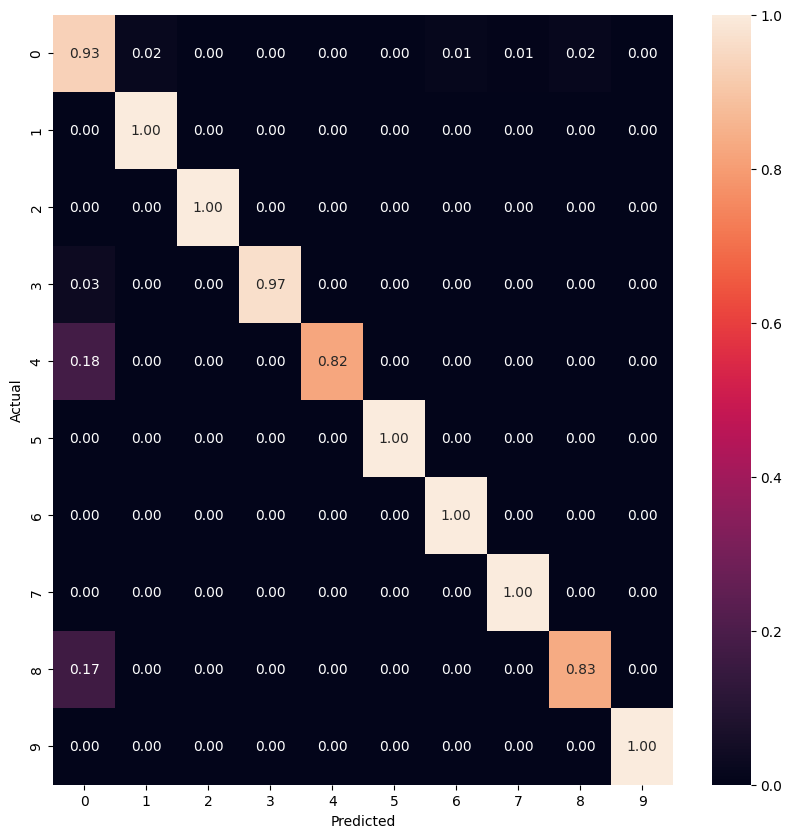

In [10]:
y_pred = model_deep(X_test)
_, predicted = torch.max(y_pred, 1)
predicted = predicted.numpy()
actual = y_test.numpy()

cm = metrics.confusion_matrix(actual,  predicted)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=np.arange(0,10), yticklabels= np.arange(0,10))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## Save

In [12]:
torch.save(model_deep, f'93F1_4layerDeep.pth')

# Wide Model

In [13]:
# Compare model sizes
model = Wide()
print("Model size:", sum([x.reshape(-1).shape[0] for x in model.parameters()])) 


cv_scores_deep = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model2 = Wide()
    acc = model_train(model2, X_train[train], y_train[train], X_train[test], y_train[test]) # Only train/test with a small sample of the data
    print("Accuracy (wide): %.2f" % acc)
    cv_scores_deep.append(acc)

# evaluate the model
wide_acc = np.mean(cv_scores_deep)
wide_std = np.std(cv_scores_deep)
print("Wide: %.2f%% (+/- %.2f%%)" % (wide_acc, wide_std))

# rebuild model with full set of training data
print("Retrain a wide model")
model_wide = Wide()
acc = model_train(model_wide, X_train, y_train, X_test, y_test, train_again = True)

print(f"Final model accuracy: {acc:.2f}%")

Model size: 1994
Accuracy (wide): 80.95
Accuracy (wide): 80.08
Accuracy (wide): 80.16
Accuracy (wide): 82.25
Accuracy (wide): 80.98
Wide: 80.88% (+/- 0.78%)
Retrain a wide model
Final model accuracy: 87.71%


## CM

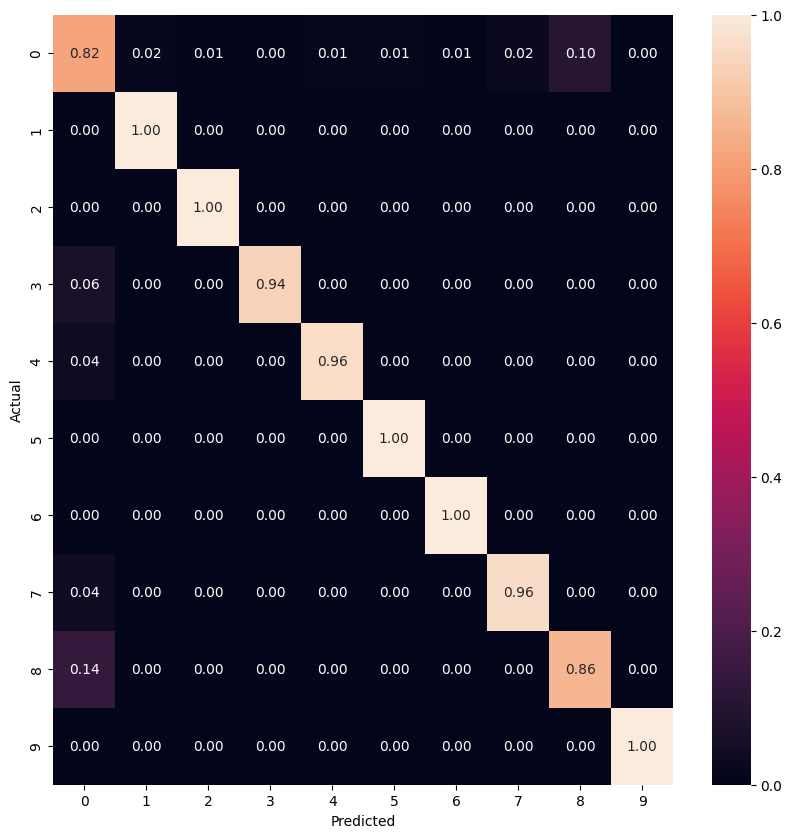

In [15]:
y_pred = model_wide(X_test)
_, predicted = torch.max(y_pred, 1)
predicted = predicted.numpy()
actual = y_test.numpy()

cm = metrics.confusion_matrix(actual,  predicted)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=np.arange(0,10), yticklabels= np.arange(0,10))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

# Decreasing Model

In [18]:
# Compare model sizes
model = Decreasing()
print("Model size:", sum([x.reshape(-1).shape[0] for x in model.parameters()]))  # 11041

cv_scores_deep = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model3 = Decreasing()
    acc = model_train(model3, X_train[train], y_train[train], X_train[test], y_train[test]) # Only train/test with a small sample of the data
    print("Accuracy (decreasing): %.2f" % acc)
    cv_scores_deep.append(acc)

# evaluate the model
dec_acc = np.mean(cv_scores_deep)
dec_std = np.std(cv_scores_deep)
print("Decreasing: %.2f%% (+/- %.2f%%)" % (dec_acc, dec_std))

# rebuild model with full set of training data
print("Retrain a decreasing model")
model_decreasing = Decreasing()
acc = model_train(model_decreasing, X_train, y_train, X_test, y_test, train_again = True)

print(f"Final model accuracy: {acc:.2f}%")

Model size: 5950
Accuracy (decreasing): 87.13
Accuracy (decreasing): 86.94
Accuracy (decreasing): 87.13
Accuracy (decreasing): 87.20
Accuracy (decreasing): 89.10
Decreasing: 87.50% (+/- 0.80%)
Retrain a decreasing model
Final model accuracy: 92.54%


## CM

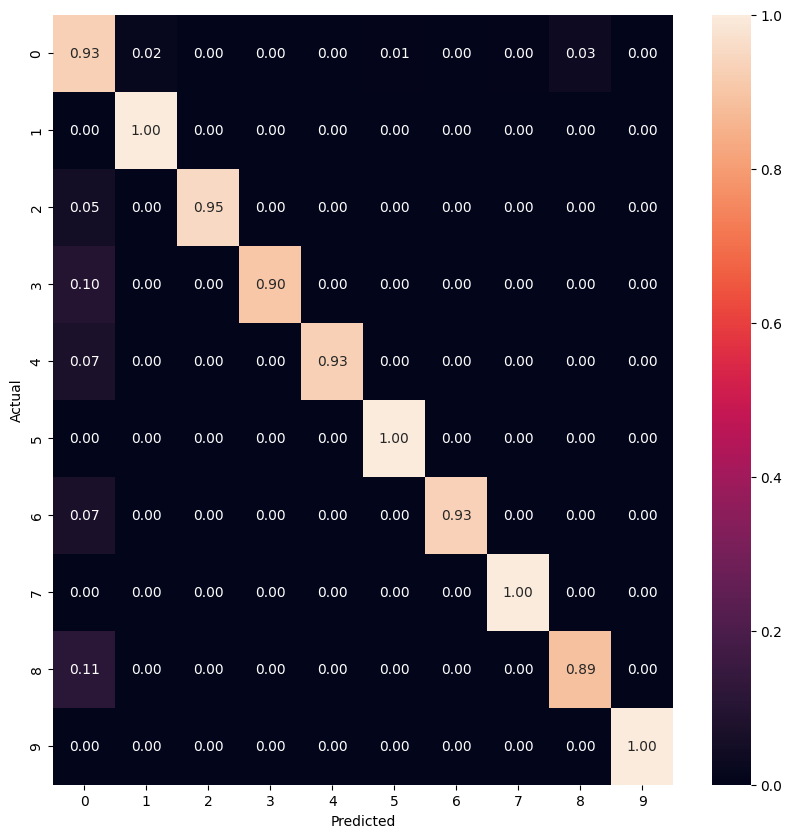

In [19]:
y_pred = model_decreasing(X_test)
_, predicted = torch.max(y_pred, 1)
predicted = predicted.numpy()
actual = y_test.numpy()

cm = metrics.confusion_matrix(actual,  predicted)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=np.arange(0,10), yticklabels= np.arange(0,10))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

# Wider Model

In [ ]:
# Compare model sizes
model = Wider()
print("Model size:", sum([x.reshape(-1).shape[0] for x in model.parameters()]))  # 11041


cv_scores_wider = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model4 = Decreasing()
    acc = model_train(model4, X_train[train], y_train[train], X_train[test], y_train[test]) # Only train/test with a small sample of the data
    print("Accuracy (wider): %.2f" % acc)
    cv_scores_wider.append(acc)

# evaluate the model
wider_acc = np.mean(cv_scores_wider)
wider_std = np.std(cv_scores_wider)
print("Wider: %.2f%% (+/- %.2f%%)" % (wider_acc, wider_std))

# rebuild model with full set of training data
print("Retrain a wider model")
model_wider = Wider()
acc = model_train(model_wider, X_train, y_train, X_test, y_test, train_again = True)

print(f"Final model accuracy: {acc:.2f}%")

Model size: 5714
Accuracy (decreasing): 79.33
Accuracy (decreasing): 69.69
Accuracy (decreasing): 75.27
Accuracy (decreasing): 71.57
Accuracy (decreasing): 80.77
Decreasing: 75.33% (+/- 4.28%)
Retrain a decreasing model
Final model accuracy: 90.44%


In [ ]:
y_pred = model_wider(X_test)
_, predicted = torch.max(y_pred, 1)
predicted = predicted.numpy()
actual = y_test.numpy()

cm = metrics.confusion_matrix(actual,  predicted)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=np.arange(0,10), yticklabels= np.arange(0,10))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

# Test TP data

In [8]:
TP_df = pd.read_csv('5datasets_13&14&17Jul.csv', sep = ';')

In [99]:
# Read data
data = TP_df
X_TP = data.drop(columns = ['AP']) 
X_norm = df.drop(columns = ['AP'])
for c in X_TP.columns:
    X_TP[c] = X_TP[c] / X_norm[c].abs().max()
y_TP = data['AP']

encoder = LabelEncoder()
encoder.fit(y_TP)
y_TP = encoder.transform(y_TP)

# Convert to 2D PyTorch tensors
X_TP = torch.tensor(X_TP.values, dtype=torch.float32)
y_TP = torch.tensor(y_TP, dtype=torch.long)

F1 scores: 13%


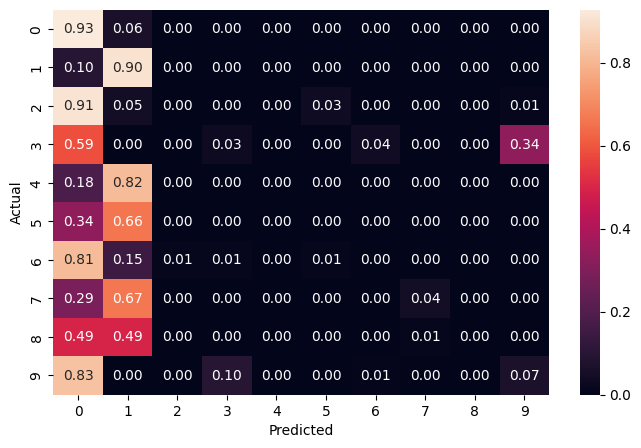

In [81]:
y_pred = model_deep(X_TP)

f1 = MulticlassF1Score(num_classes= 10)
print(f"F1 scores: {f1(y_pred, y_TP).item() * 100:.0f}%")

_, predicted = torch.max(y_pred, 1)
predicted = predicted.numpy()
actual = y_TP.numpy()

cm = metrics.confusion_matrix(actual,  predicted)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=np.arange(0,10), yticklabels= np.arange(0,10))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)
plt.show()

Very bad outcome. The Kapton data alone doesn't work well on the Tattoo Paper data. See KS&TPS noteebook.